Intro
    I have a background in networking through a job and a college class, so I started this project as an "easy" intro to data science due to it pertaining to a subject I'm familar with. Some ideas (TCP/ UDP counts, ports attacked, etc.) felt natural to look out for, especially those regarding the number of attacks in a given time frame. Much of my work was based on the assumption those attacking with a VPN/ Proxy will do so sparingly so as to not draw attention to themselves (otherwise they wouldn't use VPN/ Proxy) and those spamming likley don't care about being seen (or the attacks are automated). I was also given some advice from CrowdSec's comment about a month into the challenge, timed events. This spurred on the creation of many valuable features (number of specific attacks made by an IP in a given window, number of attacker_ip_enums using a given an attacker_as_num in a time range, etc.). With a great deal of experimentation I found the best window for my model was around eight days, and I stuck with it throughout all my measurements. 
    As uninteresting as it sounds I found CatBoost to work the best through trial and error. Boosted Forest appears to be the king in many binary classification challenges on Kaggle so it's where I started, and it's where I stayed after trying quite a few other models. I then tested between CatBoost, XGBoost, and RandomForestClassifier until I found CatBoost consistently worked better than the other two. After that I poured over the CatBoost docs finding out what each parameter did and thinking on how it could help me. Hyperparamter tuning, much like finding the right model, came down to experimentation and general recommendations from online communities (basically reading StackExchange forums that gave a range (ex. learning_rate should ideally be between 0.001 and 0.1)).
    My original script could be run without a problem on an M1 Mac, but when attempting to run on Kaggle I constantly found myself running out of available memory. If you're interested in seeing the original, feel free to reach out, I'll share it and maybe you'll have a few more suggestions you can send my way! I probably (most certainly) overused python's garbage collecting module (gc.collect()) but once I got the script in a place where it could run on Kaggle I stopped working on it and didn't risk removing anything. I learned the value of functions both because of avoiding repetition and because they discard values that aren't returned (ensuring no garbage variables stuck around). If I had more time I'd also go back through and remove creating new dataframes to perform calculations. I worked on those functions that used the most memory first and once it was in a place to run on Kaggle I stopped touching everything.

In [1]:
#Imports
#These aren't cleaned up. Many of these modules/ libraries aren't used in this notebook, but I thought it may give you a better idea of what I used to test before my final submission
import datetime
import gc
import lightgbm as lgb
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pya
import re
import scipy.stats as stats
import sklearn
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from category_encoders import *
from datetime import datetime, timedelta
from scipy.stats import zscore
from scipy.special import logsumexp
from sklearn import linear_model
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, cohen_kappa_score, f1_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, Normalizer, power_transform
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

shodan_df_hashed Feature Engineering
This function is used to feature engineer the values in shodan hashed, most notably the fingerprints. I made the assumption that those IP's sharing fingerprints (perhaps through an assignment based on their MAC address) were likely using VPN's/ Proxies. Therefore, the most valuable data here is in the IP's shared among each fingerprint. Besides that I simply counted the number of times each protocol (TCP or UDP) was used when targeting a specific port.

In [2]:
#shodanHashedAlt
def shodanHashedAlt(shodanCSV):
    
    print("\tStarting MultiIndex of Fingerprints...")
    #Adds three columns with jarm, headers_hash, and ja3s fingerprints (held as lists)
    shodanCSV = shodanCSV.replace(["'", ",", "{", "}", "None"], "", regex=True) #Removing the following characters to make regex easier, since shodan_info is imported as a string
    #Creating the pattern to collect the fingerprints, port numbers, and connection type used (storing lists in a dictionary)
    patternDict = {"jarm":"jarm: (\S+)", "headers_hash":"headers_hash: (\S+)", "ja3s":"ja3s: (\S+)", "TCPCount":"(\S*/tcp)", "UDPCount":"(\S*/udp)", "ports": "(\d+)\/"}
    for i in patternDict:   #Extracting each of these patterns and placing them in their own columns
        tempMultiIndex = shodanCSV["shodan_info"].str.extractall(patternDict[i])    #Extracting the value pattern based on the key used in the iterator i
        tempMultiIndex.columns = [i]    #Renaming the (only) column in the MultiIndex for readability during testing based on the key in the iterator i
        tempMultiIndex = tempMultiIndex.groupby(level=0)[i].apply(list)    #Grouping by the first level of the MultiIndex and turning it into a list
        shodanCSV = pd.concat([shodanCSV, tempMultiIndex], axis= 1)    #Combining shodanCSV with the MultiIndex (because indeces are saved during the extraction this is easy to do)
        tempMultiIndex = None
        """
        If this part is confusing no worries, there probably is an easier way to do it, but here's an explanation for the way this runs
        tempMultiIndex = shodanCSV["shodan_info"].str.extractall(patternDict[i])
            Creates a MultiIndex (from 0-3) like so (we'll assume it's itterating on headers_hash)...
                index row headers_hash
                1     0   ###################
                      1   ###################
                3     0   ###################
            Notice indeces 0 and 2 are missing? This is due to the regex extractall not finding a matching pattern in their shodan_df_hashed row.
            So we have attacker_ip_enum's basically kept track of by their indices and all of their headers_hash from the shodan_info column in the multi-index
        tempMultiIndex.columns = [i]
            Simply ensures (by setting it (even redudently)) the column name is the same as the key currently itterated on
        tempMultiIndex = tempMultiIndex.groupby(level=0)[i].apply(list)
            Merges the rows for each index into a list, basically turning the MultiIndex into a series or single column dataframe
            index row headers_hash
            1     0   [###################, ###################]
            3     0   [###################]
        shodanCSV = pd.concat([shodanCSV, tempMultiIndex], axis= 1)
            Joins shodanCSV with the MultiIndex. Those indeces without a list are given np.NaN as their value
        """
        
        #So now shodanCSV has the following columns: shodan_info (unchanged), attacker_ip_enum (unchanged), jarm, headers_hash, ja3s, TCPCount, UDPCount, and ports

    #Here's the plan: take in each set ONLY if it's not empty, make it a series (single column dataframe), then check each index in each set in each row for duplicates against the newly created dataframe
    fingerprintList = ["jarm", "headers_hash", "ja3s"]  #Creating a list of strings to reference each specific column of the dataframe in a for loop

    for i in fingerprintList:   #Turning each column of jarm, ja3s, and headers hash into a set of each fingerprint (some columns are empty others have multiple)            
        shodanCSV[i] = shodanCSV[i].fillna("").apply(set)   #Turned into a set so the duplicates from one IP address are removed
        #I.E. If one IP attacked multiple ports and has the same header hash twice, it will be knocked down to one so duplicates aren't found in cases where one IP attacks a port twice but no other IP uses the same header hash

    print("\tFrequency of each print...")
    #Have to make seperate dataframes due to their varying length (each column in a dataframe must have the same length, that conflicts with what I'm doing)
    #This creates a single column data frame where each row is a fingerprint. Duplicates ARE allowed, but only so long as they didn't come from the same IP because they're indexed from sets (above), which don't allow duplicates
    JARM = pd.DataFrame(list([a for b in shodanCSV["jarm"].tolist() for a in b])) #Doesn't bring over empty lists, which is ideal
    HH = pd.DataFrame(list([a for b in shodanCSV["headers_hash"].tolist() for a in b]))
    JATS = pd.DataFrame(list([a for b in shodanCSV["ja3s"].tolist() for a in b]))
    fingerprintBook = [JARM, HH, JATS]

    #Creates a column for the frequency of each fingerprint in tracking style
    #Value counts removes duplicates from the column, which is fine because the column created (count) shows how many there were
    for i in range(0, len(fingerprintBook)):
        fingerprintBook[i] = pd.DataFrame(fingerprintBook[i].value_counts())
        fingerprintBook[i] = fingerprintBook[i].reset_index(names=["unique_values"])
        fingerprintBook[i]["count"] = fingerprintBook[i]["count"] - 1     #Subtracting one because I must take into consideration the IP's fingerprint itself (so if an IP is the only one with a fingerprint, it's shared said fingerprint with no one else, resulting in a 0)
    
    #Creates a dataframe with the IPs in one column and fingerprints in the other
    #It's exploded, so there can be multiple rows with the same IP and fingerprint combo
    print("\tExploding each fingerprint type...")
    for i in range(len(fingerprintBook)):
        exploded_SHFP = pd.DataFrame(shodanCSV[fingerprintList[i]].explode()).reset_index()    #Creates an exploded dataframe of the IP and a fingerprint type (JARM, JA3s, or Headers Hash)
        
        fingerprintBook[i].set_index("unique_values", inplace= True)    #Sets the index of the fingerprint dataframe to the column of unique fingerprints (leaving the new index and a column of counts)
        exploded_SHFP = exploded_SHFP.join(fingerprintBook[i], on= fingerprintList[i])    #Joins the column of counts to the exploded fingerprint dataframe based on the fingerprints
        exploded_SHFP.drop([fingerprintList[i]], axis= 1, inplace= True)    #Drops the unique fingerprints column (no longer necessary, only need the IP and counts column)
        
        exploded_SHFP = exploded_SHFP.groupby(["index"]).agg({"count":"sum"})    #Groups by the unique IP and aggregate sums the counts column (creating a total of shared fingerprints)
        shodanCSV = shodanCSV.join(exploded_SHFP)   #Joins the counts column to shodanCSV (where all the data is stored)
        shodanCSV = shodanCSV.rename(columns= {"count": f"{fingerprintList[i]}_sum"})   #Renames the counts column to the fingerprintType_sum, so it's not overwritten when the loop reitterates
        shodanCSV[f"{fingerprintList[i]}_sum"] = shodanCSV[f"{fingerprintList[i]}_sum"].astype("float32")
    
    """
    #Iterates through the rows of shodanCSV assigning a value to fingerprint_shared column based on the count from a dictionary
    #The dictionary is created per fingerprint book and contains the unique value (fingerprint) and the count
    #The calculate_sum function finds the unique fingerprints in each row and sums their count, adding it to the fingerprint_shared column
    #This is how it was performed previously. I often ran out of memory, which I assume was due to itterating over every row coupled with incredibly long strings from the fingerprints
    print(fingerprintBook[i].info())
    
    for i in range(0, len(fingerprintBook)):
        #multi_index_sh = pd.DataFrame(shodanCSV[f"{fingerprintList[i]}"].explode()).reset_index()
        exit()
        count_mapping = dict(zip(fingerprintBook[i]["unique_values"], fingerprintBook[i]["count"]))
        shodanCSV[f"{fingerprintList[i]}_shared"] = np.vectorize(calculate_sum)(shodanCSV[fingerprintList[i]])
    """
    
    print("\tStarting Protocol Count...")
    protocolC = ["TCPCount", "UDPCount"]    #Acquiring the count of UDP and TCP protocols used in an attack (those with more are more likely to be spamming and unlikely to use a VPN (assumed out of laws reach))
    for i in protocolC:
        shodanCSV[i] = shodanCSV[i].fillna("").apply(list)    #Fills the empty values from the lists created in the loop above with my own empty value, just so I know what to reference
        shodanCSV[i] = shodanCSV[i].str.len()    #Counts the length of the list, giving the number of TCP ports and UDP ports attacked
        shodanCSV[i] = shodanCSV[i].astype("int32")
        
    #Checks for those who have attacked ports but don't have any fingerprints (this is both those with "" and None, although they are different and probably should've been treated differently)
    shodanCSV["NoPrintWithAttack"] = np.where(((shodanCSV["TCPCount"] > 0) | (shodanCSV["UDPCount"] > 0))  & ((shodanCSV["jarm"].str.len() == 0) & (shodanCSV["headers_hash"].str.len() == 0) & (shodanCSV["ja3s"].str.len() == 0)), 1, 0)
    shodanCSV["NoPrintWithAttack"] = shodanCSV["NoPrintWithAttack"].astype("int32")
    shodanCSV = shodanCSV.drop(["shodan_info", "jarm", "headers_hash", "ja3s", "ports"], axis= 1)
    
    
    return shodanCSV

General Feature Engineering
This is where most of the feature engineering takes place. More detail on each function can be found in comments around them, including their purpose.

In [3]:
def FindingAverageAttackerIPs(X, window):
    print("Finding average attacker IP's shared among")
    #Finding the average attacker IP shared amoung attacker_as_num's
    X["attacker_as_num"].replace(np.NaN, -1, inplace= True)
    X.reset_index(inplace= True)
    #Finding the unique count of attacker_ip_enum per attacker_as_num and merging the resulting column into the original dataframe
    X = pd.merge(left= X, right= X.groupby("attacker_as_num")["attacker_ip_enum"].nunique().reset_index().rename(columns= {"attacker_ip_enum": "attNumNUniqueIPs"}), on= "attacker_as_num", how= "inner")
    
    df = X[["attacker_as_num", "attacker_ip_enum", "attNumNUniqueIPs"]].copy(deep= True)  #Remaking copy with necessary columns
    X.drop(["attNumNUniqueIPs"], axis= 1, inplace= True)    #Dropping, now unneeded, attNumNUniqueIPs column
    df.drop_duplicates(subset= ["attacker_ip_enum", "attacker_as_num"], inplace= True)   #Dropping duplicates of attacker_as_num for each attacker_ip_enum
    df.drop(["attacker_as_num"], axis= 1, inplace= True) #Dropping the now unnecessary column (still segregated by unique attNumNUniqueIPs). Done in this way because some attacker_ip_enums may have multiple attacker_as_nums with the same attNumNUniqueIPs
    df = df.groupby("attacker_ip_enum")["attNumNUniqueIPs"].mean().reset_index().rename(columns= {"attNumNUniqueIPs": "avgSharedIPsWithAttHost"})  #Grabbing the mean of attNumNUniqueIPs for each attacker_ip_enum
    
    #Adding the new column to the original data frame
    X = pd.merge(left= X, right= df, on= "attacker_ip_enum", how= "inner")    #Merging the average calculated in df with the original dataframe, X
    X["avgSharedIPsWithAttHost"] = X["avgSharedIPsWithAttHost"].astype("float32")

    df = None   #Clearing for mem
    X.set_index("index", inplace= True) #Reinstating "index" column as the index
    X.sort_index(inplace= True)   #Sorting by "index" column
    return X

def FindingCountUniqueWatAttCom(X, window):
    print("Finding a count of unique")
    #Finding a count of unique Watcher_as_Num and attack_type combos in a given time frame
    X.reset_index(inplace= True)    #Resetting index to keep ordering when merging at the end
    
    #X["attack_type"] = X["attack_type"].astype("int32") #Attack_type is categorical during the XTe run through unless explicitly changed it need to be int for the unique ID made...
    X["CombWatNumAttType"] = X["watcher_as_num"] + (X["attack_type"]/1000)    #here. This takes watcher_as_num and the categorical attack_type and makes a unique ID in a float32 format (etc. watcher_as_num.0attack_type)
    df = X[["CombWatNumAttType", "attacker_ip_enum", "attack_time"]].copy(deep= True)  #Making copy of the original dataframe to perform calculations on
    
    df = df.groupby(["attacker_ip_enum", pd.Grouper(key="attack_time", freq= window)])["CombWatNumAttType"].nunique().reset_index(name= "NUniqueWattAtt")   #Creating a new value measuring the number of unique watcher_as_num+attack_type combinations in a given window
    
    X["rounded_time"] = X["attack_time"].dt.floor(window)   #Creating a new column with the value being the floor of the window of attack_time
    X = pd.merge(X, df, left_on= ["attacker_ip_enum", "rounded_time"], right_on=["attacker_ip_enum", "attack_time"])    #Merging the new column into the original dataframe based on attacker_ip_enum and the new rounded_time
    df = None   #Clearing for mem
    X.drop(["rounded_time", "attack_time_y", "CombWatNumAttType"], axis= 1, inplace= True)   #Dropping the rounded_time and attack_time column from the copied dataframe
    X = X.rename(columns= {"attack_time_x": "attack_time"}) #Renaming attack_time_x (happened during the merge) to attack_time for easier reference later
    X.set_index("index", inplace= True) #Resetting the index as it was sorted when merged
    X["NUniqueWattAtt"] = X["NUniqueWattAtt"].astype("int32")
    return X

def AddingCountAtt(X, window):
    print("Adding a count of attacks carried out")
    #Simply adding a count of attacks carried out in a given time frame (10 seconds)
    #Making a copy of the original dataframe (this will soon only contain the count by the end of this process)
    df = X.filter(["attacker_ip_enum", "attack_time"], axis= 1).copy() #Currently only contains attacker_ip_enum and attack_time, the two values it'll group and roll a window over
    
    X.to_parquet("XTemp.parq")
    X = None
    gc.collect()
    
    #Adding a column to the dataframe with the original index as the new index will be adjusted after grouping, rolling, and sorting
    df = df.reset_index()
    #Sorting the dataframe by time. To perform a rolling window the data must be chronological
    df.sort_values(by= "attack_time", inplace= True)
    #Grouping by attacker_ip_enum, then rolling a window over a period of time, and taking the count. As well as resetting the index (because groupby makes a multi-index) and makes "level_0" the new index
    #So the column called "index" becomes the count and the column "level_0" becomes the old index
    df = df.groupby(by= "attacker_ip_enum", sort= False, as_index= False).rolling("10S", center= True, on= "attack_time").count().reset_index().set_index("level_0")
    #Sorting the index (level_0, the old, original index) back into order
    df = df.sort_index(axis= 0)
    df = df.drop(["attack_time", "attacker_ip_enum"],axis= 1)   #All that remains is the index (level_0) and the count (index)
    #At this point df is an index (length of X) and a single column (the count of shared IPs in the rolling window time frame)
    
    X = pd.read_parquet("XTemp.parq")
    
    #Moving the column from df to X
    X["SharedIPsInRange"] = df["index"].values
    X["SharedIPsInRange"] = X["SharedIPsInRange"].astype("float32")
    #Clear mem space
    df = None
    return X

def NumberSpecificAtt(X, window, uniqueList= None):
    print("Number of specific types")
    #Counting the number of times an IP address issued a specific attack in a given time frame (8 Days) (for each attack except those in the list below)
    #unnecessaryAttTypes = ["windows:bruteforce_8D", "sip:bruteforce_8D", "telnet:bruteforce_8D", "smb:bruteforce", "database:bruteforce", "ftp:bruteforce"]    #Added after testing in hopes of limiting unnecessary memory usage
    unnecessaryAttTypes = [14, 9, 12, 8, 0, 1]
    
    if uniqueList is None:    #Unique List is created here for the Training data...*
        uniqueList = X["attack_type"].unique()    #This creates a list of all the unique attack types http:bruteforce, tcp:scan, etc. to iterate through and find how many occurances there are in the given window
    for i in range(len(uniqueList)):    #*... and used here for the Testing data. This is done to ensure the column ordering stays the same throughout (as is required for many models)
        if uniqueList[i] in unnecessaryAttTypes:
            pass
        else:
            print(f"\t{uniqueList[i]}")
            df = pd.DataFrame    #Creating an empty dataframe
            df = X[X["attack_type"] == uniqueList[i]].filter(["attack_time", "attacker_ip_enum"], axis= 1)  #Creates a dataframe in the list of only the attack_time and attacker_ip_enum

            X.to_parquet("XTemp.parq")
            X = None
            gc.collect()

            df.reset_index(inplace= True)    #Keeping the original index as a column as the index will be reset when groupby is used
            df.sort_values(by= "attack_time", inplace= True)    #Sorting for the sake of the rolling window
            df[f"{uniqueList[i]}_{window}"] = df.groupby(by= "attacker_ip_enum", sort= False, as_index= False)[["attacker_ip_enum", "attack_time"]].rolling(window= window, center= True, on= "attack_time").count()
            df.sort_values(by= "index", inplace= True)    #Putting the dataframe back into it's original order
            df.drop(["attack_time", "attacker_ip_enum"], axis= 1, inplace= True)   #Dropping the unecessary columns (the index and calculated data is all that matters), it's all still there in the main dataframe
            df.set_index("index", inplace= True)    #Setting the index back to the true index

            X = pd.read_parquet("XTemp.parq")

            X = pd.concat([X, df], axis= 1)    #Joining the calculated data with the original dataframe
            X[f"{uniqueList[i]}_{window}"].fillna(0, inplace= True)    #Renaming the column to attacktype_window (ex. tcp:scan_8D)
            X[f"{uniqueList[i]}_{window}"] = X[f"{uniqueList[i]}_{window}"].astype("float32")
            df = None    #Clearing for mem
    return X, uniqueList

def FindingTimeDiff(X, window):
    print("Finding the time diff between the")
    #Finding the difference in time between each attack from each attacker_ip_enum (the first attack is 0)
    df = X[["attacker_ip_enum", "attack_time"]].copy(deep= True)    #Making a copy df to perform calculations on
    
    X.to_parquet("XTemp.parq")
    X = None
    gc.collect()
    
    df["time_diff"] = df.sort_values(["attack_time"]).groupby("attacker_ip_enum")["attack_time"].diff().dt.total_seconds()  #Creating a column that measures the difference in time between one attack and the one preceding it (those without a predecessor are marked N/A)
    df["time_diff"].replace(value= 0 , to_replace= np.NaN, inplace= True)   #Changing N/A's to 0's for model's sake
    df.drop(["attacker_ip_enum", "attack_time"], axis= 1, inplace= True)    #Dropping now unnecessary columns
    
    X = pd.read_parquet("XTemp.parq")
    
    X = X.join(df, how="outer")  #Joining the calculated column with the original dataframe
    X["time_diff"] = X["time_diff"].astype("float32")
    df = None    #Clearing for mem
    return X

def AttIPNumWat(X, window):
    print("Just the number of watchers each")
    #Just the unique number of watcher_as_num each attacker_ip_enum attacked in total
    df = X[["attacker_ip_enum", "watcher_as_num"]].copy(deep= True)    #Making a copy to preserve the original dataframe
    
    X.to_parquet("XTemp.parq")
    X = None
    gc.collect()
    
    df = df.groupby("attacker_ip_enum", as_index= False)["watcher_as_num"].nunique().reset_index()    #Grouping by attacker_ip_enum and including only watcher_as_num in the data, then getting a unique count
    
    print("\t\tCollected all Nunique...")
    
    X = pd.read_parquet("XTemp.parq")
    
    X = pd.merge(X, df, how= "left", on= "attacker_ip_enum")    #Combining the calculated data from df with the original dataframe, X
    X = X.rename(columns= {"watcher_as_num_x": "watcher_as_num", "watcher_as_num_y": "WatPerAttIP"})    #Renaming the columns changed by the merge above
    X.drop("index", axis= 1, inplace= True)    #Dropping the "index" column created during the groupby
    df = None    #Clearing for mem
    return X
    
def CountAvgUniqueAttType(X, window):
    print("Counting, and then averaging, the number")
    #An average count of unique attack_types used by each attacker_ip_enum in a given window (8 minutes)
    smallWindow = "8min"    #Setting small window of 8 minutes
    X.reset_index(inplace= True)    #Resetting index incase something messes with it when merging
    df = X[["attack_type", "attacker_ip_enum", "attack_time"]].copy(deep= True) #Making a copy so changes aren't made on the original dataframe
    
    X.to_parquet("XTemp.parq")
    X = None
    gc.collect()
    
    df["attack_time"] = df["attack_time"].dt.floor(smallWindow) #Changing the time to a rounded floor based on the small window variable
    #Grouping by attacker_ip_enum and the floored time range to find the number of unique attack_type's used. Basically the count of unique attack_type's used by each attacker_ip_enum in each 8 minute window
    df = df.groupby(["attacker_ip_enum", pd.Grouper(key="attack_time", freq= smallWindow)])["attack_type"].nunique().reset_index(name= f"NUniqueAttackType_{smallWindow}")
    df.drop(["attack_time"], axis= 1, inplace= True)    #Dropping the, now unnecessary, rounded attack_time column from the dataframe being worked on
    df = df.groupby(["attacker_ip_enum"])[f"NUniqueAttackType_{smallWindow}"].mean().reset_index()  #Grouping by attacker_ip_enum and averaging every 8 minute window where they attacked
    
    X = pd.read_parquet("XTemp.parq")
    
    X = pd.merge(X, df, left_on=["attacker_ip_enum"], right_on=["attacker_ip_enum"])    #Merging the worked on dataframe with the original
    X.set_index("index", inplace= True) #As expected the index was adjusted, but it can re-added to it's orignal state with this line
    X["NUniqueAttackType_8min"] = X["NUniqueAttackType_8min"].astype("float32")
    df = None   #Of course, clearing the worked on dataframe to save some memory
    return X

FEAll Data Function
This simply calls all the functions above (including shodanHashedAlt)

In [4]:
#Feature Engineering the main dataset
def FEAllData(X, uniqueList = None):
    #Dropping unused features
    
    #https://www.kaggle.com/code/pavansanagapati/14-simple-tips-to-save-ram-memory-for-1-gb-dataset  
    
    X = X.drop(["watcher_as_name", "attacker_as_name", "watcher_uuid_enum", "watcher_country", "attacker_country"], axis=1)
    window = "8D"   #Setting window frame for time measurements

##########################################################################################################################################################################################################

    #Performing data engineering with shodan_df_hashed throught the shodanHashedAlt function
    print("Starting shodanHashed...")
    if(uniqueList is None):    #This means shodanHashedAlt hasn't run yet because it's the first time this function (FEAllData) is being used (since uniqueList is filled in when FEAllData is run once)
        X.to_parquet("XTemp.parq")   #Storing the dataframe in the harddrive to save on RAM
        
        shodanCSV = pd.read_csv("/kaggle/input/vpn-classification/dataset_v2/shodan_df_hashed.csv")
        shodanCSV = shodanHashedAlt(shodanCSV)    #Gathering the features from shodan_df_hashed

        X = pd.read_parquet("XTemp.parq")    #Re-reading in the main dataframe
    
    else:    #Meaning shodanCSV has already had feature engineering performed on it
        shodanCSV = pd.read_parquet("shodanHashedTemp.parq")
    
    #Combining ShodanCSV DF and the main features DF based on attacker_ip_enum
    X = X.reset_index().merge(shodanCSV, how = "left", on="attacker_ip_enum").set_index("index")
    shodanCSV.to_parquet("shodanHashedTemp.parq")    #Storing shodanCSV to a parq for future use/ reference
    shodanCSV = None    #Saving memory
    gc.collect()

##########################################################################################################################################################################################################
    
    #Counting, and then averaging, the number of unique attack_type's used by attacker_ip_enum's in a given (smaller) window
    X = CountAvgUniqueAttType(X, window)
    gc.collect()
    
##########################################################################################################################################################################################################    

    #Finding average attacker IP's shared among attacker_as_num's used by each attacker_ip_enum
    X = FindingAverageAttackerIPs(X, window)
    gc.collect()

##########################################################################################################################################################################################################
    
    #Finding a count of unique watcher_as_num+attack_type combinations in a given time frame (as was suggested by the article posted by CrowdSec in the community tab (but slightly adjusted))
    X = FindingCountUniqueWatAttCom(X, window)
    gc.collect()
    
##########################################################################################################################################################################################################

    #Adding a count of attacks carried out, with the same IP, in a designated window
    X = AddingCountAtt(X, window)
    gc.collect()
    
##########################################################################################################################################################################################################

    #Finding the time diff between the attack and the one before
    X = FindingTimeDiff(X, window)
    gc.collect()
    
##########################################################################################################################################################################################################
    
    #Just the number of watchers each attacker_ip_enum has attacked in the whole dataset
    X = AttIPNumWat(X, window)
    gc.collect()
    
##########################################################################################################################################################################################################
    
    #Number of specific types of attacks in a time range
    X, uniqueList = NumberSpecificAtt(X, window, uniqueList)
    gc.collect()
    
##########################################################################################################################################################################################################
    
    #Dropping (now) unnecessary columns
    X = X.drop(["attack_time", "watcher_as_num", "attacker_as_num"], axis= 1)
#https://stackoverflow.com/questions/52693482/merging-pandas-data-frames-uses-way-too-much-memory
    return X, uniqueList

One Hot Encoding Function
Used to transform the Ordinally Encoded attack_type column into multiple binary columns. I did this to avoid implied ranking from the Ordinal Encoding previously performed on the attack_type column. I also drop columns that, through experimentation, catboost doesn't consider useful to save memory and (in some cases) increase the score.

In [5]:
#One Hot Encoding Protocol and Attack Type Together, done in this way so rank isn't assumed in the OrdinalEncoded attack_type column
def OneHotEncoding(X, OHEncoder = None):
    print("Starting One Hot Encoding...")
    toOHE = ["attack_type"]   #Specifying what column to encode
    if(OHEncoder == None):
        OHEncoder = OneHotEncoder(handle_unknown= "ignore", sparse_output= False)    #Setting one hot encoder
        OHEncoder.fit(X[toOHE])    #Fitting the encoder on the training data
    
    OHXT = pd.DataFrame(OHEncoder.transform(X[toOHE]))    #Encoding the column from the training data
    OHXT = OHXT.astype("bool")      #Ensuring the columns are bool types (taking up less memory than int64 or string)
    X = X.drop(toOHE, axis= 1)   #Dropping the one hot encoded column from the training data
    OHXT.index = X.index    #Ensuring the indeces between the two dataframes are the same
    X = pd.concat([X, OHXT], axis= 1)   #Moving the data from the one hot encoding dataframe to the original

    #Setting the column names as strings (or, rather, ensuring they are) (as is required for some models during testing)
    X.columns = X.columns.astype(str)
    #Dropping Columns
    print("Dropping unnecessary columns...")

    toDrop = ["14", "9", "12", "8", "0", "1"]    #Creating list of columns to drop
    X.drop(toDrop, axis= 1, inplace= True)
    
    return X, OHEncoder

Ordinal Encoding Function
I used ordinal encoding on attack_type only as it was the sole feature missing a numerical representation. It came in handy for functions like FindingCountUniqueAttWat because it could be added as a decimal place, assisting in the creation of unique ID's using two numerical features. The downside is, as Kaggle's tutorials point out, so models consider this a ranking. To alleviate this, the final step before averaging all the data, is transforming this column into many with a One Hot Encoder.

In [6]:
def OrdinalEncoding(X, OrdEncode = None):
    print("Starting Ordinal Encoding...")   #Fit on attack_type so the values between each are smaller than strings and can be synced between XTr/ XTe
    if(OrdEncode == None):  #Assuming OrdEncode isn't being passed into the argument (XTr) it will be created. If it is being passed in (XTe) then it doesn't need to be created and is already fit to XTr
        OrdEncode = OrdinalEncoder()    #Creating the OrdinalEncoder
        OrdEncode.fit(X[["attack_type"]])   #Fitting it to attack_type alone
    X["attack_type"] = OrdEncode.transform(X[["attack_type"]]).astype(int)  #Transforming the attack_type column to the fit OrdinalEncoder
    X["attack_type"] = X["attack_type"].astype("int32") #Ensuring the new attack_type column is int32 to avoid unnecessary memory usage
    return X, OrdEncode

Averaging and Slimming Function

In [7]:
def averageSlimming(X, y = None):
    #Averaging/ Counting everything (making each attacker_ip_enum unique to the attacker_ip_enum column, i.e. no duplicates (easier on memory and how the submission was requested (i.e. not classifying every instance, just every IP)))
    print("Finding Averages...")
    toAverage = list(X.columns)    #Creating a list of all columns present in the X dataframe
    stayingSame = ["attacker_ip_enum", "TCPCount", "UDPCount", "jarm_sum", "ja3s_sum", "headers_hash_sum", "NoPrintWithAttack"]    #Specifying which columns should not be averaged
    toAverage = [column for column in toAverage if column not in stayingSame]   #Creating a list of columns to be averaged based on all columns that are present in the dataframe but not in the stayingSame list
    colDict = dict.fromkeys(stayingSame, "first")    #Creating a dictionary indicating that all columns in stayingSame should only take the first value present...
    colDict.update(dict.fromkeys(toAverage, "mean")) #While those in the toAverage column will have the mean taken and saved

    X = X.groupby("attacker_ip_enum", as_index= False).agg(colDict)    #Grouping by attacker_ip_enum, then keeping the first of the stayingSame columns and the average of the toAverage columns
    X.sort_values(by= ["attacker_ip_enum"], inplace= True)    #Sorting by attacker_ip_enum to ensure consistency between indexes

    if(y is not None):    #If y came into the function as a dataframe (meaning it's XTr's pair)
        y.drop_duplicates(subset= "attacker_ip_enum", inplace= True, keep= "first")    #Dropping duplicate values in the y training dataframe
        y.sort_values(by= ["attacker_ip_enum"], inplace= True)    #Sorting by attacker_ip_enum to ensure consistency between indexes (X and y, similar to above)
        y.drop(["attacker_ip_enum"], axis= 1, inplace= True)    #Dropping attacker_ip_enum so it doesn't interfere with the models fit

    else:    #If no y was input into the dataframe (i.e. XTe is being used and a predictions dataframe needs to be created)
        y = X["attacker_ip_enum"].copy(deep= True)    #The yTe predictions dataframe is created
    
    X.drop(["attacker_ip_enum"], axis= 1, inplace= True)    #attacker_ip_enum is not useful for the model so it's dropped
    
    print(X.shape)
    print(y.shape)
    
    return X, y   #Returning X and y dataframes (XTr and yTr (for model fitting) or XTe and yTe (for model predicting))
    

Reading in Training Data and calling Feature Engineering functions on it

In [8]:
#Could try changing the order so datetime column is dropped near the start (equivalent size as float64)

#Reading in the data
XTr = pd.read_parquet("/kaggle/input/vpn-classification/dataset_v2/train.parq")
gc.enable()
#Creating XTrain, yTrain, etc. as well as calling feature engineering function
yTr = XTr[["attacker_ip_enum", "label"]].copy(deep= True)    #Keeping attacker_ip_enum in there so when I average XTr later the same adjustment can be made to yTr. This ensure the indeces aren't out of order
XTr.drop(["label"], axis= 1, inplace= True)    #Dropping "label" from XTr

XTr, OrdEnc = OrdinalEncoding(XTr)  #Ordinal Encoding attack_type
gc.collect()

XTr, uniqueList = FEAllData(XTr)    #Performing feature engineering on XTr and creating a unique list
gc.collect()
XTr, OHEnc = OneHotEncoding(XTr)    #OneHotEncoding attack_type
gc.collect()

print(XTr.info())

XTr, yTr = averageSlimming(XTr, yTr)    #Averaging data based on attack_ip_enum and slimming it down to one instance of each attacker_ip_enum per dataframe

Starting Ordinal Encoding...
Starting shodanHashed...
	Starting MultiIndex of Fingerprints...
	Frequency of each print...
	Exploding each fingerprint type...
	Starting Protocol Count...
Counting, and then averaging, the number
Finding average attacker IP's shared among
Finding a count of unique
Adding a count of attacks carried out
Finding the time diff between the
Just the number of watchers each
		Collected all Nunique...
Number of specific types
	4
	6
	2
	5
	13
	7
	10
	11
	3
Starting One Hot Encoding...
Dropping unnecessary columns...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61629685 entries, 0 to 61629684
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   attacker_ip_enum         int32  
 1   TCPCount                 int32  
 2   UDPCount                 int32  
 3   jarm_sum                 float32
 4   headers_hash_sum         float32
 5   ja3s_sum                 float32
 6   NoPrintWithAttack        int32  

Fitting the model and reading in/ Feature Engineering the testing data
Displaying feature importance was valuable when cutting out data to meet memory requirements (even before attempting to fit into Kaggle's standards). I kept the columns out as catboost determined them unnecessary (with 0 or extremely close 0 value).

Fitting the model...
	 Fitting Now
	Finished Fitting


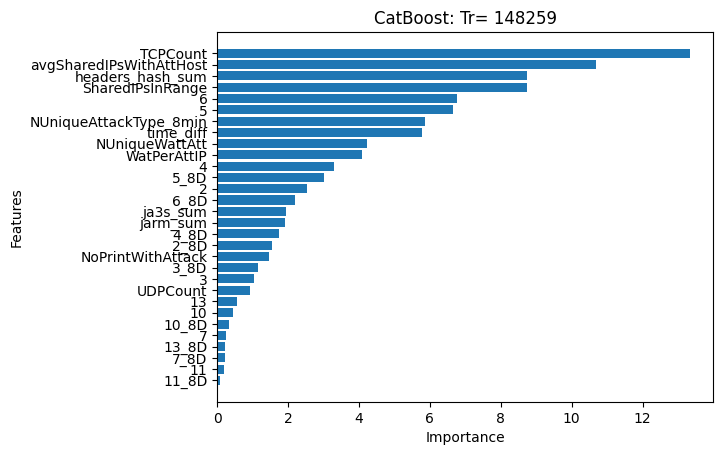

In [9]:
#Fitting the model and displaying feature importance (as chosen by CatBoost)
print("Fitting the model...")
model = CatBoostClassifier(depth=8, early_stopping_rounds= 5, learning_rate= 0.05, subsample= 0.70, colsample_bylevel= 0.65, min_data_in_leaf= 50, scale_pos_weight= 4.0, silent= True)
print("\t Fitting Now")
model.fit(XTr,yTr)
print("\tFinished Fitting")

#Determing and displaying feature importance (Catboost only)
importances = model.get_feature_importance(type= "PredictionValuesChange")
feature_importances = pd.Series(importances, index= XTr.columns).sort_values()
plt.barh(feature_importances.index, feature_importances.values)
plt.title(f"CatBoost: Tr= {len(XTr)}")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [10]:
XTe = pd.read_parquet("/kaggle/input/vpn-classification/dataset_v2/test.parq")
#Same process as that seen with XTr BUT with the fit for Ordinal Encoder, One Hot Encoder, and the uniqueList used in NumberSpecificAtt function being present and passed into the functions
XTe, OrdEnc = OrdinalEncoding(XTe, OrdEnc)
OrdEnc = None
gc.collect()

XTe, uniqueList = FEAllData(XTe, uniqueList)
uniqueList = None
ShodanHashed = None
gc.collect()

XTe, OHEnc = OneHotEncoding(XTe, OHEnc)
OHEnc = None
gc.collect()

print(XTe.info)

XTe, XTe_AttIPEnum = averageSlimming(XTe)

Starting Ordinal Encoding...
Starting shodanHashed...
Counting, and then averaging, the number
Finding average attacker IP's shared among
Finding a count of unique
Adding a count of attacks carried out
Finding the time diff between the
Just the number of watchers each
		Collected all Nunique...
Number of specific types
	4
	6
	2
	5
	13
	7
	10
	11
	3
Starting One Hot Encoding...
Dropping unnecessary columns...
<bound method DataFrame.info of           attacker_ip_enum  TCPCount  UDPCount  jarm_sum  headers_hash_sum  \
0                     7696        16         1    4493.0            1444.0   
1                     7696        16         1    4493.0            1444.0   
2                     7696        16         1    4493.0            1444.0   
3                     7696        16         1    4493.0            1444.0   
4                     7696        16         1    4493.0            1444.0   
...                    ...       ...       ...       ...               ...   
18682292  

Writing out predictions

In [11]:
#Predicting yTe and saving it to a CSV
predicts = pd.DataFrame(model.predict(XTe.values))

submission = pd.concat([XTe_AttIPEnum, predicts], axis= 1, join= "inner")    #Combining the attacker_ip_enum only dataframe (with no duplicate IPs) with the prediction made above
submission.columns = ["attacker_ip_enum", "label"]    #Ensuring the columns are properly labeled
print(submission.info)
#submission.sort_values(by= ["attacker_ip_enum"], axis= 1, inplace= True)

submission.to_csv("submission.csv", index= False)
print(XTe.head(5))
print("Number of each: ", submission.value_counts("label"))    #To get an idea of how many are positive/ negative (assuming ~3-5% should be positive)

<bound method DataFrame.info of        attacker_ip_enum  label
0                     5      0
1                     7      0
2                    21      0
3                    29      0
4                    33      0
...                 ...    ...
49415            199947      0
49416            199949      0
49417            199962      0
49418            199964      0
49419            199966      0

[49420 rows x 2 columns]>
   TCPCount  UDPCount  jarm_sum  ja3s_sum  headers_hash_sum  \
0         2         0       0.0       0.0             187.0   
1         5         1      28.0      12.0            1674.0   
2         0         0       0.0       0.0               0.0   
3         1         0       0.0       0.0             145.0   
4         0         0       0.0       0.0               0.0   

   NoPrintWithAttack  NUniqueAttackType_8min  avgSharedIPsWithAttHost  \
0                  0                2.961539                     26.0   
1                  0                1.000000

Due to the stochasticity of col_sample and sub_sample in Catboost results may vary. They generally come out to around the same f1 score with positive/ negative predictions fluctuating by +/- 20